# Analysing accuracy data for different days of the week

The idea of this notebook is to analyse the trained data on fc_train for a specific day of the week, with the objective to try to understand the differences in the accuracy between specific days in the week, and what could possibly be the model weak points. We are going to modify the code from the file fc_evaluate.py, to make sure we evaluate for different parameters.

First, we need to train the data. Here we are using the data from the GEFCOM files to train the model.

In [1]:
!python3 fc_train.py

No missing data 

--- Loading existing log file ---
Size training set: 	86919
Size validation set: 	18626
Begin training,	 tensorboard log here:	 /home/jupyter/profiles/gal/ProLoaF-Training/runs/2021-04-30 16-56-40/
Epoch 1/18	 train_loss -8.60e-01	 val_loss -1.29e+00	 elapsed_time 1.70e+01
Epoch 2/18	 train_loss -1.24e+00	 val_loss -1.48e+00	 elapsed_time 1.70e+01
Epoch 3/18	 train_loss -1.33e+00	 val_loss -1.52e+00	 elapsed_time 1.70e+01
Epoch 4/18	 train_loss -1.37e+00	 val_loss -1.55e+00	 elapsed_time 1.70e+01
Epoch 5/18	 train_loss -1.40e+00	 val_loss -1.58e+00	 elapsed_time 1.70e+01
Epoch 6/18	 train_loss -1.42e+00	 val_loss -1.59e+00	 elapsed_time 1.70e+01
Epoch 7/18	 train_loss -1.44e+00	 val_loss -1.59e+00	 elapsed_time 1.70e+01
Epoch 8/18	 train_loss -1.45e+00	 val_loss -1.62e+00	 elapsed_time 1.70e+01
Epoch 9/18	 train_loss -1.47e+00	 val_loss -1.64e+00	 elapsed_time 1.70e+01
Epoch 10/18	 train_loss -1.48e+00	 val_loss -1.65e+00	 elapsed_time 1.70e+01
Epoch 11/18	 train_loss

The next four blocks are from fc_evaluate.py. That file reads the raw data used to train the model, makes a prediction based on a part of the raw data, and with that we can measure the accuracy of the model using different methods.  

In [2]:
from fc_evaluate import shape_model_input, results_table, evaluate_hours, plot_metrics
import utils.datatuner as dt
import utils.tensorloader as dl
import utils.eval_metrics as metrics
import utils.modelhandler as mh
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from utils.config_util import read_config, parse_basic

# TODO: find workaround for PICP numpy issue
import numpy as np
import pandas as pd
import torch
import warnings
import matplotlib.pyplot as plt
import sys
import os

In [3]:
MAIN_PATH = os.path.abspath('../')#os.path.dirname(os.path.dirname(os.path.realpath(__file__)))
sys.path.append(MAIN_PATH)

warnings.filterwarnings('ignore')

In [4]:
ARGS = parse_basic()
print(ARGS)
PAR = read_config(model_name=ARGS.station, config_path=ARGS.config, main_path=MAIN_PATH)

# DEFINES
torch.manual_seed(1)
INFILE = os.path.join(MAIN_PATH, PAR['data_path'])  # input factsheet
# after training
INMODEL = os.path.join(MAIN_PATH, PAR['output_path'], PAR['model_name'])
OUTDIR = os.path.join(MAIN_PATH, PAR['evaluation_path'])

target_id = PAR['target_id']
DEVICE = 'cpu'
SPLIT_RATIO = PAR['validation_split']

HISTORY_HORIZON = PAR['history_horizon']
FORECAST_HORIZON = PAR['forecast_horizon']
feature_groups = PAR['feature_groups']

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

# Read load data
df = pd.read_csv(INFILE, sep=';')
df = dt.fill_if_missing(df)

if ('target_list' in PAR):
    if(PAR['target_list'] is not None):
        df[target_id] = df[PAR['target_list']].sum(axis=1)

Namespace(config=None, station='gefcom2017/nh_data')
No missing data 



                    MSE      RMSE  Mean sharpness  Mean PICP   Mean IS
gc17nh_GRU_gnll  0.0165  0.128452        0.541925  97.509842  0.635716


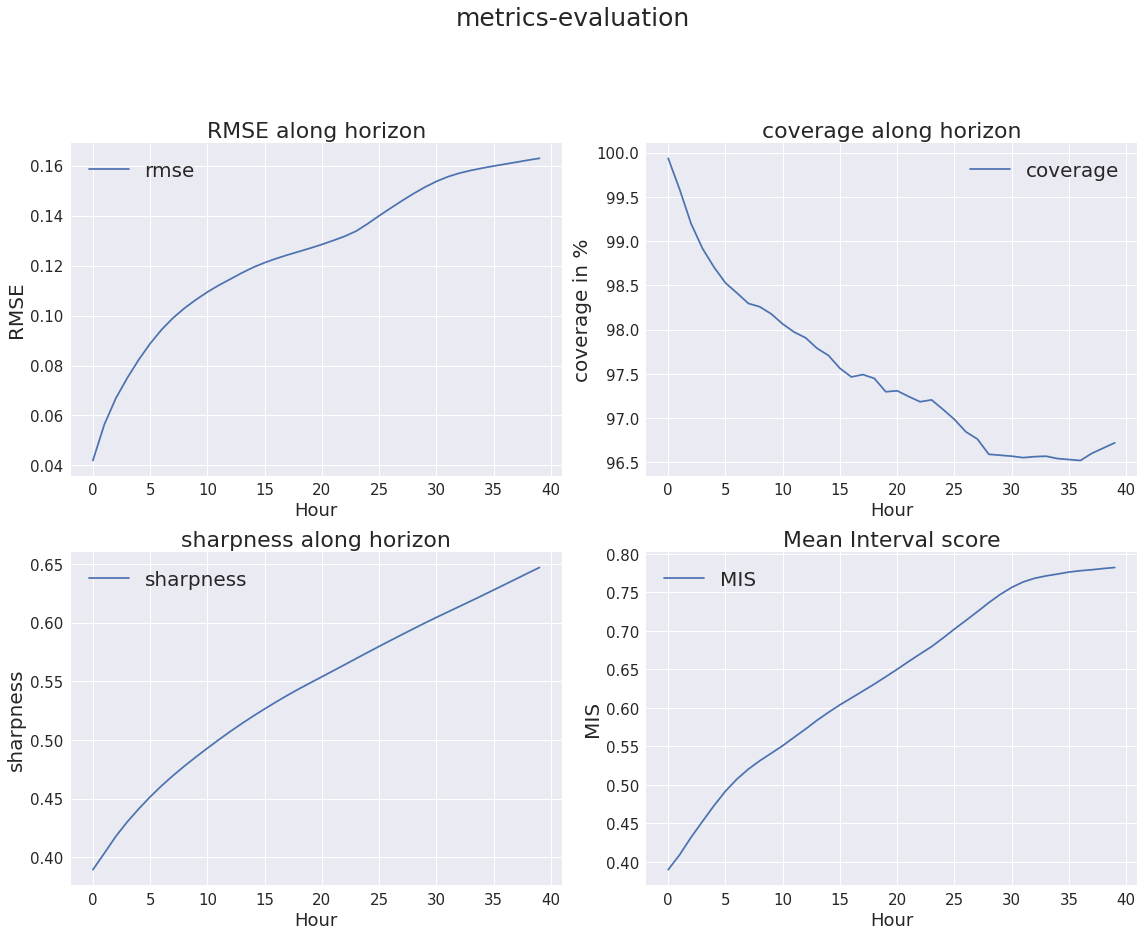

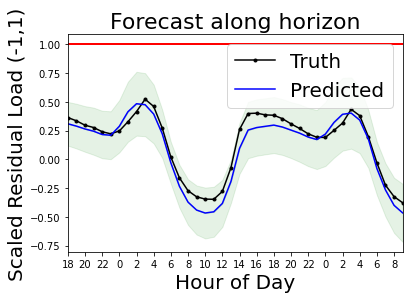

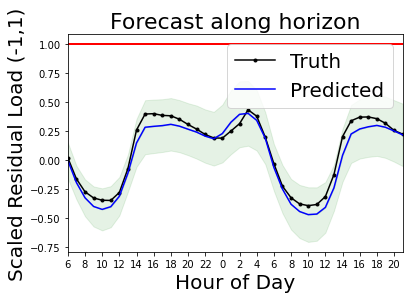

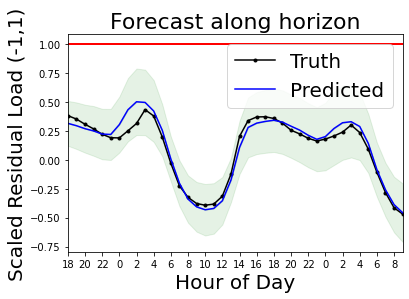

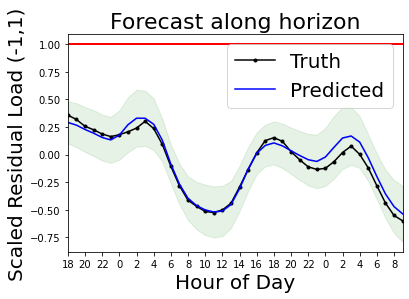

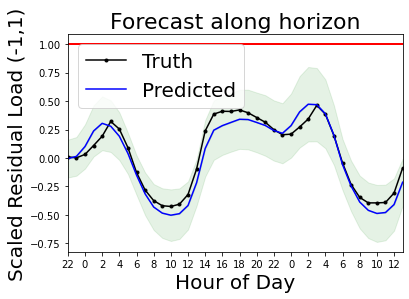

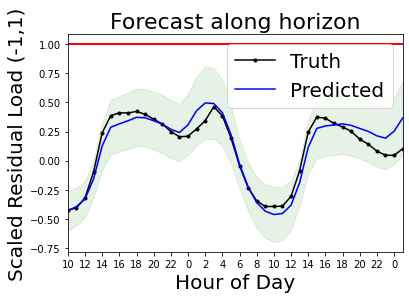

In [5]:
with torch.no_grad():
    net = torch.load(INMODEL, map_location=torch.device(DEVICE))  # mapping to CPU

    df_new, _ = dt.scale_all(df, **PAR)

    target_index = df_new.columns.get_loc(target_id)

    split_index = int(len(df_new.index) * SPLIT_RATIO)
    test_df = df_new.iloc[split_index:]
    
    test_data_loader = dl.make_dataloader(test_df, target_id, PAR['encoder_features'], PAR['decoder_features'],
                                              history_horizon=PAR['history_horizon'], forecast_horizon=PAR['forecast_horizon'],
                                              shuffle=False).to(DEVICE)
    
    # check performance
    horizon = test_data_loader.dataset.targets.shape[1]
    number_of_targets = test_data_loader.dataset.targets.shape[2]

    record_targets, record_output = mh.get_prediction(net, test_data_loader, horizon, number_of_targets)

    net.eval()
    # TODO: check model type (e.g gnll)
    criterion = net.criterion
    #print(record_targets)
    #print('-----------')
    #print(record_output)
    # get metrics parameters
    
    y_pred_upper, y_pred_lower, record_expected_values = mh.get_pred_interval(record_output, criterion, record_targets)

    # rescale(test_output, test_targets)
    # dt.rescale_manually(..)

    # calculate the metrics
    mse_horizon = metrics.mse(record_targets, [record_expected_values], total=False)
    rmse_horizon = metrics.rmse(record_targets, [record_expected_values], total=False)
    sharpness_horizon = metrics.sharpness(None, [y_pred_upper, y_pred_lower], total=False)
    coverage_horizon = metrics.picp(record_targets, [y_pred_upper,
                                                        y_pred_lower], total=False)
    mis_horizon = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05, total=False)

    # collect metrics by disregarding the development over the horizon
    mse = metrics.mse(record_targets, [record_expected_values])
    rmse = metrics.rmse(record_targets, [record_expected_values])
    sharpness = metrics.sharpness(None, [y_pred_upper, y_pred_lower])
    coverage = metrics.picp(record_targets, [y_pred_upper,
                                                        y_pred_lower])
    mis = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05)

    # plot metrics
    plot_metrics(rmse_horizon.detach().numpy(), sharpness_horizon.detach().numpy(), coverage_horizon.detach().numpy(), mis_horizon.detach().numpy(), OUTDIR, 'metrics-evaluation')

    # plot forecast for sample days
    # testhours = [0, 12, 24, 48, 100, 112]

    if 'ci_tests' in PAR['data_path']:
        testhours = [0, 12]
    else:
        testhours = [0, 12, 24, 48, 100, 112]

    actual_time = pd.to_datetime(df.loc[split_index:, 'Time'])
    for i in testhours:
        hours = actual_time.iloc[i:i + FORECAST_HORIZON]
        evaluate_hours(record_targets[i].detach().numpy(), record_expected_values[i].detach().numpy(), y_pred_upper[i].detach().numpy(), y_pred_lower[i].detach().numpy(), i, OUTDIR, PAR['cap_limit'], hours)

    target_stations = [PAR['model_name']]
    print(results_table(target_stations, mse.detach().numpy(), rmse.detach().numpy(), sharpness.detach().numpy(), coverage.detach().numpy(), mis.detach().numpy()))

But how should we get the specific accuracy measurement for a day of the week? For this, it is necessary to just use, for example, the data from monday when predicting the values. The variables used in the prediction are 'record_targets' and 'record_output'. 'record_targets' is a tensor that contains the values from the demand, the same in the dataframe for that specific time. Each element of 'record_targets' contains an array with length equal to the forecast horizon, because we want to predict in the horizon given. The second hour in the first sample becomes the first hour in the second sample.

In [6]:
record_targets, record_targets.shape

(tensor([[[ 0.3627],
          [ 0.3344],
          [ 0.2962],
          ...,
          [-0.2246],
          [-0.3245],
          [-0.3777]],
 
         [[ 0.3344],
          [ 0.2962],
          [ 0.2762],
          ...,
          [-0.3245],
          [-0.3777],
          [-0.3927]],
 
         [[ 0.2962],
          [ 0.2762],
          [ 0.2396],
          ...,
          [-0.3777],
          [-0.3927],
          [-0.3827]],
 
         ...,
 
         [[-0.6242],
          [-0.4807],
          [-0.3360],
          ...,
          [-0.1291],
          [-0.1667],
          [-0.3200]],
 
         [[-0.4807],
          [-0.3360],
          [-0.2271],
          ...,
          [-0.1667],
          [-0.3200],
          [-0.5108]],
 
         [[-0.3360],
          [-0.2271],
          [-0.1709],
          ...,
          [-0.3200],
          [-0.5108],
          [-0.6565]]]),
 torch.Size([18547, 40, 1]))

'record_output' is a tensor that contains the prediction values as an output on the neural network model. The first dimension size is equal to the length of 'test_df' minus both the forecast and history horizons. The second dimension length is equal to the forecast horizon and the third dimesion is equal to two (the expected value and the standard deviation of the prediction). Each element has the rows equal to the forecast horizon, while the first column is the expected value of the demand and the second column is the standard deviation of the prediction. This is because we used the gaussian loss while training (default setting).

In [7]:
record_output, record_output.shape

(tensor([[[ 0.3087, -4.6694],
          [ 0.2883, -4.6230],
          [ 0.2636, -4.5823],
          ...,
          [-0.2663, -4.2706],
          [-0.4001, -4.2018],
          [-0.4658, -4.0991]],
 
         [[ 0.2810, -4.7151],
          [ 0.2491, -4.6932],
          [ 0.2339, -4.6141],
          ...,
          [-0.3938, -4.2176],
          [-0.4587, -4.1201],
          [-0.4850, -4.0683]],
 
         [[ 0.2455, -4.7514],
          [ 0.2279, -4.6751],
          [ 0.2065, -4.6336],
          ...,
          [-0.4543, -4.1343],
          [-0.4803, -4.0827],
          [-0.4762, -4.1255]],
 
         ...,
 
         [[-0.5148, -4.7190],
          [-0.3683, -4.8225],
          [-0.2158, -4.9992],
          ...,
          [-0.1009, -4.1208],
          [-0.1055, -4.3291],
          [-0.2241, -4.5006]],
 
         [[-0.3936, -5.0471],
          [-0.2186, -5.2007],
          [-0.1149, -5.1670],
          ...,
          [-0.1123, -4.3769],
          [-0.2303, -4.5352],
          [-0.4241, -4.4681

Knowing that, to measure the accuracy of the model according to a specific day of the week, we could remove the elements in both tensors above that do not correspond to the time frame that we want to analyse. To do that, we could use the variable 'test_df' to help select the right data, because both tensors are based on this dataframe. Note that we do not have the timestamps in the variable 'test_df'. To solve this problem, we do add a datetime information to the 'test_df' dataframe.

In [8]:
test_df['Time'] = df['Time']

In [9]:
test_df['Time']

105545    2015-03-16 18:00:00
105546    2015-03-16 19:00:00
105547    2015-03-16 20:00:00
105548    2015-03-16 21:00:00
105549    2015-03-16 22:00:00
                 ...         
124166    2017-04-30 19:00:00
124167    2017-04-30 20:00:00
124168    2017-04-30 21:00:00
124169    2017-04-30 22:00:00
124170    2017-04-30 23:00:00
Name: Time, Length: 18626, dtype: object

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18626 entries, 105545 to 124170
Data columns (total 47 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   demand     18626 non-null  float64
 1   drybulb    18626 non-null  float64
 2   dewpnt     18626 non-null  float64
 3   hour_0     18626 non-null  int64  
 4   hour_1     18626 non-null  int64  
 5   hour_2     18626 non-null  int64  
 6   hour_3     18626 non-null  int64  
 7   hour_4     18626 non-null  int64  
 8   hour_5     18626 non-null  int64  
 9   hour_6     18626 non-null  int64  
 10  hour_7     18626 non-null  int64  
 11  hour_8     18626 non-null  int64  
 12  hour_9     18626 non-null  int64  
 13  hour_10    18626 non-null  int64  
 14  hour_11    18626 non-null  int64  
 15  hour_12    18626 non-null  int64  
 16  hour_13    18626 non-null  int64  
 17  hour_14    18626 non-null  int64  
 18  hour_15    18626 non-null  int64  
 19  hour_16    18626 non-null  int64  
 20  

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124171 entries, 0 to 124170
Data columns (total 53 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        124171 non-null  int64  
 1   Time         124171 non-null  object 
 2   demand       124171 non-null  float64
 3   drybulb      124171 non-null  int64  
 4   dewpnt       124171 non-null  int64  
 5   date         124171 non-null  object 
 6   year         124171 non-null  int64  
 7   hour         124171 non-null  int64  
 8   day_of_year  124171 non-null  int64  
 9   trend        124171 non-null  float64
 10  hour_0       124171 non-null  int64  
 11  hour_1       124171 non-null  int64  
 12  hour_2       124171 non-null  int64  
 13  hour_3       124171 non-null  int64  
 14  hour_4       124171 non-null  int64  
 15  hour_5       124171 non-null  int64  
 16  hour_6       124171 non-null  int64  
 17  hour_7       124171 non-null  int64  
 18  hour_8       124171 non-

Now, to make use of the timestamp it is just needed to convert to a datetime variable and add two columns: one called weekday and another called hour. 'dt.weekday' returns the day of the week, with 0 being Monday and 6 being Sunday. 'dt.hour' returns the hour.

In [12]:
test_df['Time'] = pd.to_datetime(test_df['Time'])
test_df['Weekday'] = test_df['Time'].dt.weekday
test_df['Hour'] = test_df['Time'].dt.hour

In [13]:
test_df

,demand,drybulb,dewpnt,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Time,Weekday,Hour
105545,0.202995,0.049180,-0.259259,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2015-03-16 18:00:00,0,18
105546,0.324459,0.000000,-0.259259,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2015-03-16 19:00:00,0,19
105547,0.246256,-0.098361,-0.166667,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2015-03-16 20:00:00,0,20
105548,0.061564,-0.131148,-0.129630,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2015-03-16 21:00:00,0,21
105549,-0.166389,-0.196721,-0.055556,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2015-03-16 22:00:00,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124166,-0.129101,0.163934,0.259259,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017-04-30 19:00:00,6,19
124167,-0.166677,0.131148,0.240741,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017-04-30 20:00:00,6,20
124168,-0.319977,0.114754,0.222222,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017-04-30 21:00:00,6,21
124169,-0.510770,0.114754,0.222222,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2017-04-30 22:00:00,6,22


Now, we could select the day that we want to analyse by getting the 'df_test' row number that is equal to the day that we want to analyse, and then remove the other elements of the tensors, just like an array. For this example we are using weekday equal to one, a Tuesday.

In [14]:
df_indexes = (test_df[test_df['Weekday']==1].index.values)
df_indexes

array([105551, 105552, 105553, ..., 124048, 124049, 124050])

There is a important difference between the size tensors of the and the 'test_df' dataframe. The first element of the tensors correspond to the n-th row of the 'test_df' dataframe, with n being the history horizon. The last element of the tensors correspond to the m-th row of the 'test_df' dataframe, with m being the length of the dataframe minus the forecast horizon.

In [15]:
first_element = test_df.iloc[HISTORY_HORIZON].name
print(first_element)
#last_element = len(record_output) + first_element - 1
last_element = test_df.iloc[len(test_df)-FORECAST_HORIZON].name
print(last_element)

105585
124131


Now we just convert the index numbers to rows, starting by zero

In [16]:
df_indexes = [x for x in df_indexes if x >= first_element and x <= last_element ]
df_indexes = np.array([x-first_element for x in df_indexes])

In [17]:
df_indexes,len(df_indexes)

(array([  134,   135,   136, ..., 18463, 18464, 18465]), 2640)

In [18]:
test_df.iloc[df_indexes+HISTORY_HORIZON]

,demand,drybulb,dewpnt,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,Time,Weekday,Hour
105719,-0.346090,-0.327869,-0.370370,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2015-03-24 00:00:00,1,0
105720,-0.394343,-0.344262,-0.388889,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,2015-03-24 01:00:00,1,1
105721,-0.394343,-0.360656,-0.388889,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,2015-03-24 02:00:00,1,2
105722,-0.391015,-0.426230,-0.370370,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,2015-03-24 03:00:00,1,3
105723,-0.307820,-0.393443,-0.388889,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,2015-03-24 04:00:00,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124046,0.084579,0.098361,0.314815,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2017-04-25 19:00:00,1,19
124047,0.013251,0.098361,0.314815,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2017-04-25 20:00:00,1,20
124048,-0.151428,0.098361,0.314815,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2017-04-25 21:00:00,1,21
124049,-0.358414,0.098361,0.333333,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2017-04-25 22:00:00,1,22


Now we just need to convert the tensors 'record_targets' and 'record_outputs' to contain just those specific weekdays. It is possible to convert these tensors to lists, and just make a new tensor by selecting just the data from the weekday that we want to analyse.

In [19]:
record_targets_list = record_targets.tolist()
record_output_list = record_output.tolist()

In [20]:
df_indexes[-1]
len(record_targets_list)

18547

In [21]:
record_targets = torch.Tensor([record_targets_list[x] for x in df_indexes])
record_output = torch.Tensor([record_output_list[x] for x in df_indexes])

In [22]:
record_targets

tensor([[[-3.4609e-01],
         [-3.9434e-01],
         [-3.9434e-01],
         ...,
         [ 9.1514e-02],
         [ 3.4942e-02],
         [ 1.1647e-02]],

        [[-3.9434e-01],
         [-3.9434e-01],
         [-3.9101e-01],
         ...,
         [ 3.4942e-02],
         [ 1.1647e-02],
         [ 2.1631e-02]],

        [[-3.9434e-01],
         [-3.9101e-01],
         [-3.0782e-01],
         ...,
         [ 1.1647e-02],
         [ 2.1631e-02],
         [ 8.9850e-02]],

        ...,

        [[-1.5143e-01],
         [-3.5841e-01],
         [-5.2120e-01],
         ...,
         [-5.1747e-04],
         [ 3.8120e-03],
         [-1.6970e-02]],

        [[-3.5841e-01],
         [-5.2120e-01],
         [-6.2489e-01],
         ...,
         [ 3.8120e-03],
         [-1.6970e-02],
         [-2.5035e-02]],

        [[-5.2120e-01],
         [-6.2489e-01],
         [-6.8032e-01],
         ...,
         [-1.6970e-02],
         [-2.5035e-02],
         [-4.8556e-02]]])

Now we can apply everything learned above and makes the changes in the code to analyse the accuracy of the model for Tuesday! 

                      MSE      RMSE  Mean sharpness  Mean PICP   Mean IS
gc17nh_GRU_gnll  0.016257  0.127501        0.544856  98.161934  0.603541


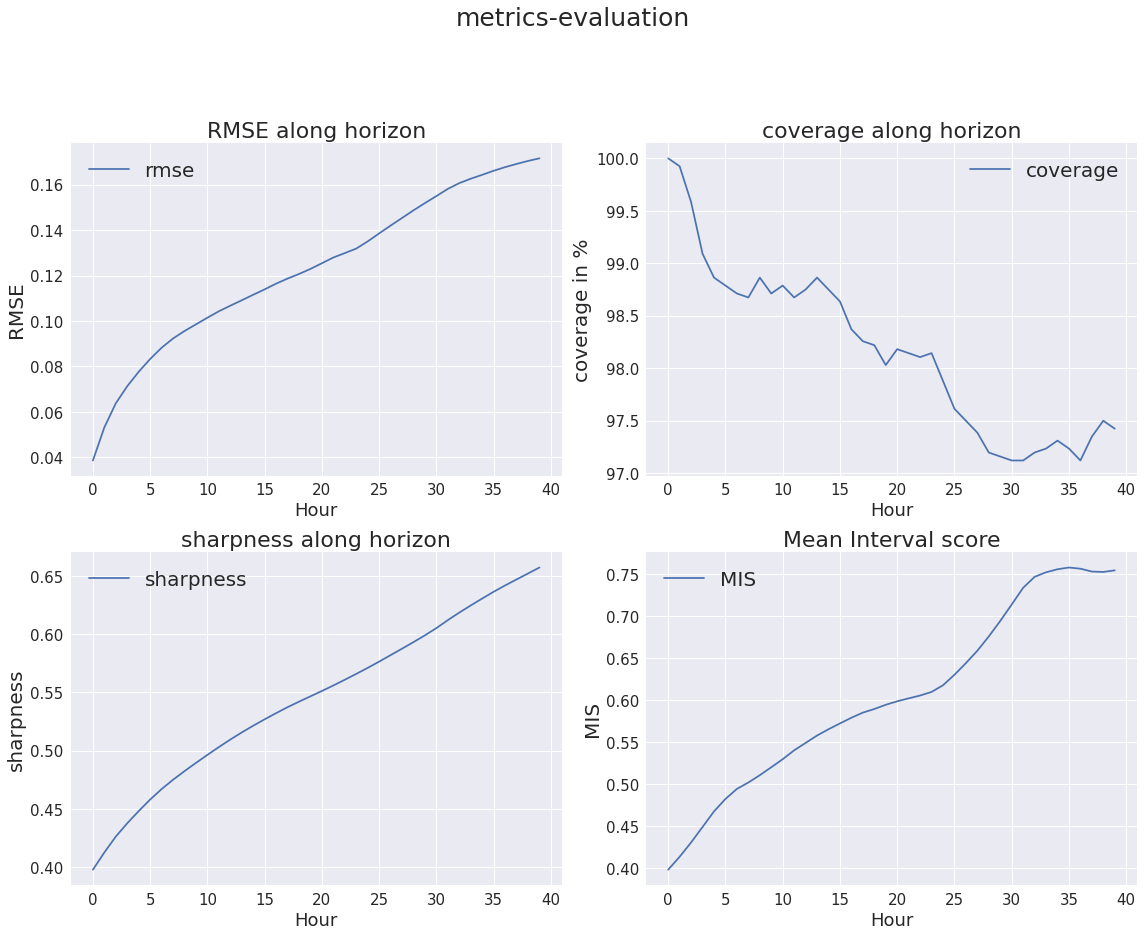

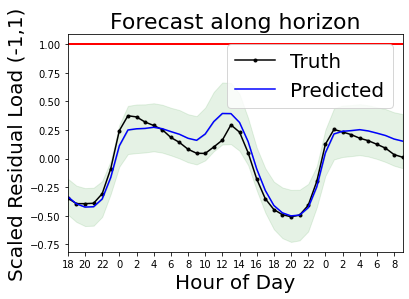

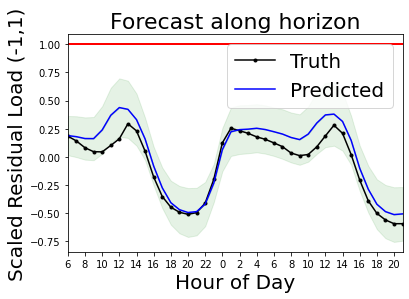

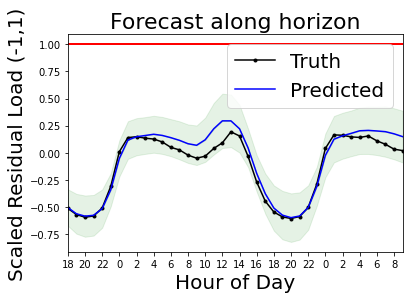

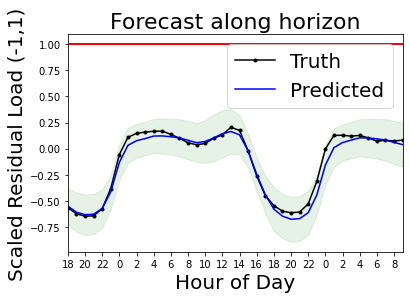

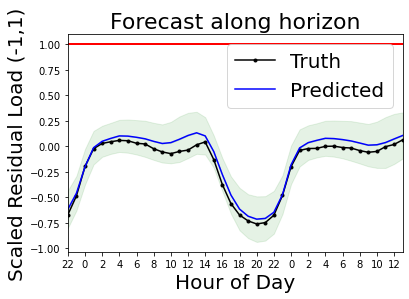

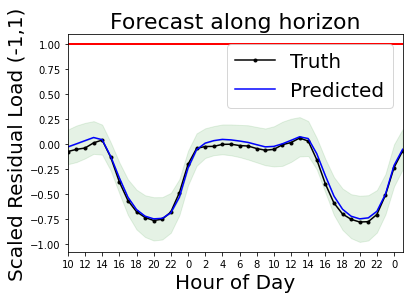

In [23]:
with torch.no_grad():
    net = torch.load(INMODEL, map_location=torch.device(DEVICE))  # mapping to CPU

    df_new, _ = dt.scale_all(df, **PAR)

    target_index = df_new.columns.get_loc(target_id)

    split_index = int(len(df_new.index) * SPLIT_RATIO)
    test_df = df_new.iloc[split_index:]
    
    test_data_loader = dl.make_dataloader(test_df, target_id, PAR['encoder_features'], PAR['decoder_features'],
                                              history_horizon=PAR['history_horizon'], forecast_horizon=PAR['forecast_horizon'],
                                              shuffle=False).to(DEVICE)
    
    # check performance
    horizon = test_data_loader.dataset.targets.shape[1]
    number_of_targets = test_data_loader.dataset.targets.shape[2]
    
    test_df['Time'] = df['Time']
    test_df['Time'] = pd.to_datetime(test_df['Time'])
    test_df['Weekday'] = test_df['Time'].dt.weekday
    test_df['Hour'] = test_df['Time'].dt.hour
    df_indexes = (test_df[test_df['Weekday']==1].index.values)
    first_element = test_df.iloc[HISTORY_HORIZON].name
    #last_element = len(record_output) + first_element - 1
    last_element = test_df.iloc[len(test_df)-FORECAST_HORIZON].name
    df_indexes = [x for x in df_indexes if x >= first_element and x <= last_element ]
    df_indexes = [x-first_element for x in df_indexes]
    
    record_targets, record_output = mh.get_prediction(net, test_data_loader, horizon, number_of_targets)
    record_targets_list = record_targets.tolist()
    record_output_list = record_output.tolist()
    record_targets = torch.Tensor([record_targets_list[x] for x in df_indexes])
    record_output = torch.Tensor([record_output_list[x] for x in df_indexes])
    #print(record_targets)
    #print(record_output)
    
    net.eval()
    # TODO: check model type (e.g gnll)
    criterion = net.criterion
    #print(record_targets)
    #print('-----------')
    #print(record_output)
    # get metrics parameters
    
    y_pred_upper, y_pred_lower, record_expected_values = mh.get_pred_interval(record_output, criterion, record_targets)

    # rescale(test_output, test_targets)
    # dt.rescale_manually(..)

    # calculate the metrics
    mse_horizon = metrics.mse(record_targets, [record_expected_values], total=False)
    rmse_horizon = metrics.rmse(record_targets, [record_expected_values], total=False)
    sharpness_horizon = metrics.sharpness(None, [y_pred_upper, y_pred_lower], total=False)
    coverage_horizon = metrics.picp(record_targets, [y_pred_upper,
                                                        y_pred_lower], total=False)
    mis_horizon = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05, total=False)

    # collect metrics by disregarding the development over the horizon
    mse = metrics.mse(record_targets, [record_expected_values])
    rmse = metrics.rmse(record_targets, [record_expected_values])
    sharpness = metrics.sharpness(None, [y_pred_upper, y_pred_lower])
    coverage = metrics.picp(record_targets, [y_pred_upper,
                                                        y_pred_lower])
    mis = metrics.mis(record_targets, [y_pred_upper, y_pred_lower], alpha=0.05)

    # plot metrics
    plot_metrics(rmse_horizon.detach().numpy(), sharpness_horizon.detach().numpy(), coverage_horizon.detach().numpy(), mis_horizon.detach().numpy(), OUTDIR, 'metrics-evaluation')

    # plot forecast for sample days
    # testhours = [0, 12, 24, 48, 100, 112]

    if 'ci_tests' in PAR['data_path']:
        testhours = [0, 12]
    else:
        testhours = [0, 12, 24, 48, 100, 112]

    actual_time = pd.to_datetime(df.loc[split_index:, 'Time'])
    for i in testhours:
        hours = actual_time.iloc[i:i + FORECAST_HORIZON]
        evaluate_hours(record_targets[i].detach().numpy(), record_expected_values[i].detach().numpy(), y_pred_upper[i].detach().numpy(), y_pred_lower[i].detach().numpy(), i, OUTDIR, PAR['cap_limit'], hours)

    target_stations = [PAR['model_name']]
    print(results_table(target_stations, mse.detach().numpy(), rmse.detach().numpy(), sharpness.detach().numpy(), coverage.detach().numpy(), mis.detach().numpy()))